In [1]:
!pip install chainer==7.7.0

     |████████████████████████████████| 11.2 MB 5.2 MB/s 
  Created wheel for chainer: filename=chainer-7.7.0-py3-none-any.whl size=967522 sha256=3bded7a427afde311e47a7b5cfcb3a728af4df8f1becc2ea2606a28fec5600ba
  Stored in directory: /root/.cache/pip/wheels/4f/c2/ca/e46a1181cc92ebe6e2d117a5cd29da5bcfc8464e00edb2cac0
Successfully built chainer


In [2]:
import chainer

In [3]:
import cv2
import csv
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow # for image display
import numpy as np
import pandas as pd
from skimage import io
from PIL import Image 

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%cd /content/
!rm -rf hyperface
!git clone https://github.com/alvaro-neira/hyperface.git --branch colab
%cd hyperface/
!git fetch --all
!git pull origin colab


/content
Cloning into 'hyperface'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 279 (delta 37), reused 36 (delta 15), pack-reused 218
Receiving objects: 100% (279/279), 8.36 MiB | 25.04 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/content/hyperface
Fetching origin
From https://github.com/alvaro-neira/hyperface
 * branch            colab      -> FETCH_HEAD
Already up to date.


In [6]:
%cd /content/hyperface/scripts

/content/hyperface/scripts


In [7]:
pre_trained = '/content/drive/MyDrive/ai/model_epoch_190'

In [8]:
import chainer

import cv2
import os
import numpy as np

import config

# Disable type check in chainer
import models

os.environ["CHAINER_TYPE_CHECK"] = "0"


def _cvt_variable(v):
    # Convert from chainer variable
    if isinstance(v, chainer.variable.Variable):
        v = v.data
        if hasattr(v, 'get'):
            v = v.get()
    return v


def short_hyperface(config_path, img_path, model_path):
    # Load config
    config.load(config_path)

    # Define a model
    model = models.HyperFaceModel()
    model.train = False
    model.report = False
    model.backward = False

    # Initialize model
    chainer.serializers.load_npz(model_path, model)

    # Setup GPU
    if config.gpu >= 0:
        chainer.cuda.check_cuda_available()
        chainer.cuda.get_device(config.gpu).use()
        model.to_gpu()
        xp = chainer.cuda.cupy
    else:
        xp = np

    # Load image file
    img = cv2.imread(img_path)
    if img is None or img.size == 0 or img.shape[0] == 0 or img.shape[1] == 0:
        exit()
    img = img.astype(np.float32) / 255.0  # [0:1]
    img = cv2.resize(img, models.IMG_SIZE)
    img = cv2.normalize(img, None, -0.5, 0.5, cv2.NORM_MINMAX)
    img = np.transpose(img, (2, 0, 1))

    # Create single batch
    imgs = xp.asarray([img])
    x = chainer.Variable(imgs)  # , volatile=True)

    # Forward
    y = model(x)

    # Chainer.Variable -> np.ndarray
    detection = _cvt_variable(y['detection'])
    genders = _cvt_variable(y['gender'])

    gender = genders[0]

    if gender > 0.5:
        return f"Female, detection={detection[0]}"
    else:
        return f"Male, detection={detection[0]}"

In [9]:
print(short_hyperface('/content/hyperface/scripts/config.json','/content/drive/MyDrive/ai/faces1/tv24horas_2021_12_07_01_face1.png',pre_trained))

Male, detection=0.9737507104873657


In [10]:
%cd /content/hyperface/scripts

/content/hyperface/scripts


In [11]:
import chainer

import cv2
import os
import numpy as np

import config
# from drawingmod import draw_pose, draw_gender, draw_detection, draw_landmark
import models

# Disable type check in chainer
os.environ["CHAINER_TYPE_CHECK"] = "0"


def _cvt_variable(v):
    # Convert from chainer variable
    if isinstance(v, chainer.variable.Variable):
        v = v.data
        if hasattr(v, 'get'):
            v = v.get()
    return v


def frame_detect(img):
    # Load config
    config.load('/content/hyperface/config.json')

    # Define a model
    model = models.HyperFaceModel()
    model.train = False
    model.report = False
    model.backward = False

    # Initialize model
    chainer.serializers.load_npz(pre_trained, model)

    xp = np

    if img is None or img.size == 0 or img.shape[0] == 0 or img.shape[1] == 0:
        exit()
    frame = img.copy()
    frame = frame.astype(np.float32) / 255.0  # [0:1]
    frame = cv2.resize(frame, models.IMG_SIZE)
    frame = cv2.normalize(frame, None, -0.5, 0.5, cv2.NORM_MINMAX)
    frame = np.transpose(frame, (2, 0, 1))

    # Create single batch
    imgs = xp.asarray([frame])
    x = chainer.Variable(imgs)  # , volatile=True)

    y = model(x)

    # Chainer.Variable -> np.ndarray
    imgs = _cvt_variable(y['img'])
    detections = _cvt_variable(y['detection'])
    landmarks = _cvt_variable(y['landmark'])
    visibilities = _cvt_variable(y['visibility'])
    poses = _cvt_variable(y['pose'])
    genders = _cvt_variable(y['gender'])

    # Use first data in one batch
    frame = imgs[0]
    detection = detections[0]
    landmark = landmarks[0]
    visibility = visibilities[0]
    pose = poses[0]
    gender = genders[0]

    frame = np.transpose(frame, (1, 2, 0))
    frame = frame.copy()
    frame += 0.5  # [-0.5:0.5] -> [0:1]
    detection = (detection > 0.5)
    gender = (gender > 0.5)

    # Draw results
    # draw_detection(frame, detection)
    landmark_color = (0, 1, 0) if detection == 1 else (0, 0, 1)
    # draw_landmark(frame, landmark, visibility, landmark_color, 0.5)
    # draw_pose(frame, pose)
    # draw_gender(frame, gender)

    return 255 * frame


def test():
    lena = frame_detect(cv2.imread('/Users/aneira/hyperface/sample_images/lena_face.png'))
    cv2.imshow('result', lena / 255)
    cv2.waitKey(0)
    cv2.imwrite('/Users/aneira/hyperface/sample_images/lena_face_result3.png', lena, [cv2.IMWRITE_PNG_COMPRESSION, 0])


[2022/01/13 06:41:02] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:02] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:02] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:02] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:02] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:02] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:02] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:02] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:02] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:02] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:02] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:02] ERROR (83) config : Conflict in con

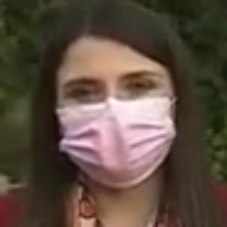

[2022/01/13 06:41:05] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:05] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:05] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:05] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:05] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:05] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:05] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:05] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:05] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:05] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:05] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:05] ERROR (83) config : Conflict in con

det_82.43_9.91.png





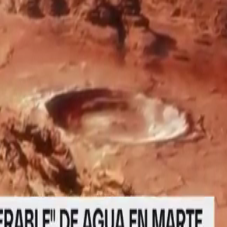

[2022/01/13 06:41:08] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:08] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:08] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:08] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:08] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:08] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:08] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:08] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:08] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:08] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:08] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:08] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_18_06_face1.png





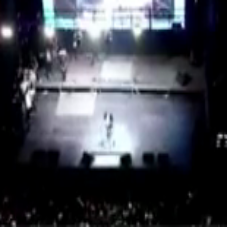

[2022/01/13 06:41:10] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:10] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:10] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:10] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:10] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:10] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:10] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:10] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:10] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:10] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:10] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:10] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_19_23_face1.png





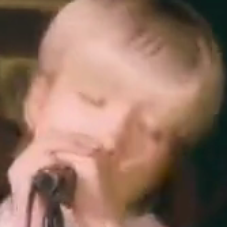

[2022/01/13 06:41:13] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:13] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:13] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:13] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:13] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:13] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:13] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:13] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:13] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:13] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:13] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:13] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_17_17_face1.png





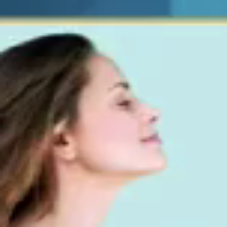

[2022/01/13 06:41:16] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:16] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:16] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:16] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:16] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:16] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:16] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:16] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:16] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:16] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:16] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:16] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_31_23_face1.png





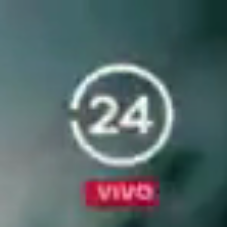

[2022/01/13 06:41:19] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:19] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:19] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:19] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:19] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:19] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:19] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:19] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:19] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:19] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:19] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:19] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_17_19_face1.png





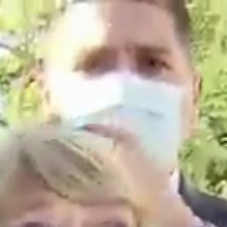

[2022/01/13 06:41:22] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:22] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:22] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:22] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:22] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:22] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:22] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:22] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:22] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:22] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:22] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:22] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_19_10_face1.png





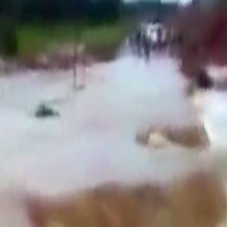

[2022/01/13 06:41:24] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:24] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:24] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:24] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:24] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:24] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:24] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:24] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:24] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:24] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:24] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:24] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_22_11_face1.png





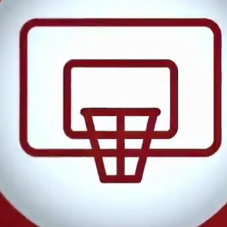

[2022/01/13 06:41:27] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:27] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:27] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:27] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:27] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:27] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:27] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:27] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:27] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:27] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:27] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:27] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_25_16_face1.png





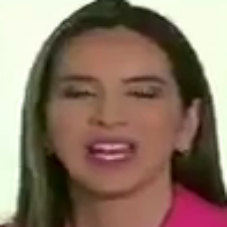

[2022/01/13 06:41:30] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:30] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:30] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:30] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:30] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:30] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:30] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:30] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:30] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:30] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:30] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:30] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_19_17_face1.png





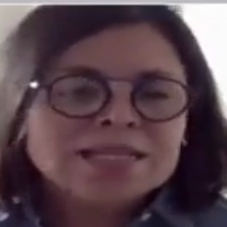

[2022/01/13 06:41:33] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:33] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:33] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:33] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:33] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:33] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:33] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:33] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:33] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:33] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:33] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:33] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_26_16_face1.png





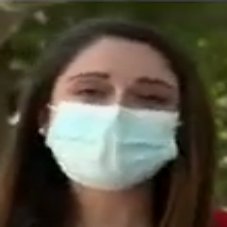

[2022/01/13 06:41:36] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:36] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:36] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:36] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:36] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:36] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:36] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:36] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:36] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:36] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:36] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:36] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_27_18_face1.png





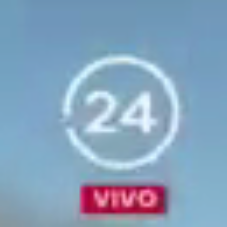

[2022/01/13 06:41:39] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:39] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:39] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:39] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:39] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:39] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:39] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:39] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:39] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:39] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:39] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:39] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_26_22_face1.png





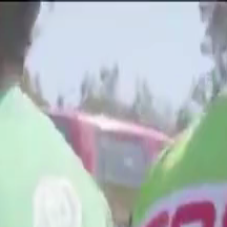

[2022/01/13 06:41:41] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:41] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:41] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:41] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:41] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:41] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:41] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:41] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:41] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:41] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:41] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:41] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_29_21_face1.png





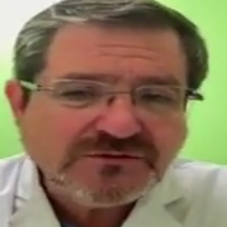

[2022/01/13 06:41:44] DEBUG (83) PIL.PngImagePlugin : STREAM b'IHDR' 16 13
[2022/01/13 06:41:44] DEBUG (83) PIL.PngImagePlugin : STREAM b'IDAT' 41 8192
[2022/01/13 06:41:44] INFO (83) config : Load config from "/content/hyperface/config.json"
[2022/01/13 06:41:44] ERROR (83) config : Conflict in config with key "aflw_sqlite_path"
[2022/01/13 06:41:44] ERROR (83) config : Conflict in config with key "aflw_imgdir_path"
[2022/01/13 06:41:44] ERROR (83) config : Conflict in config with key "aflw_cache_path"
[2022/01/13 06:41:44] ERROR (83) config : Conflict in config with key "aflw_test_rate"
[2022/01/13 06:41:44] ERROR (83) config : Conflict in config with key "alexnet_caffemodel_path"
[2022/01/13 06:41:44] ERROR (83) config : Conflict in config with key "gpu"
[2022/01/13 06:41:44] ERROR (83) config : Conflict in config with key "n_loaders_train"
[2022/01/13 06:41:44] ERROR (83) config : Conflict in config with key "n_loaders_test"
[2022/01/13 06:41:44] ERROR (83) config : Conflict in con

Copy of tv24horas_2021_12_30_16_face1.png





In [ ]:
for filename in os.listdir("/content/drive/MyDrive/ai/faces"):
    if not filename.endswith(".png"):
        continue
    img_path = os.path.join("/content/drive/MyDrive/ai/faces", filename)
    image_swapped = io.imread(f"{img_path}")
    image_2 = cv2.cvtColor(image_swapped, cv2.COLOR_BGR2RGB)
    image3 = frame_detect(image_2)
    cv2_imshow(image3)
    print(filename)
    print('\n\n')
